# 多层感知机
## 方法一

In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Generate dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

(800, 2) (800,) (200, 2) (200,)


In [5]:
class SimpleMLP:
    def __init__(self, input_size, hidden_size, output_size):
        self.W1 = torch.randn(input_size, hidden_size, requires_grad=True)
        self.b1 = torch.randn(1, hidden_size, requires_grad=True)
        self.W2 = torch.randn(hidden_size, output_size, requires_grad=True)
        self.b2 = torch.randn(1, output_size, requires_grad=True)

    def forward(self, X):
        self.z1 = torch.matmul(X, self.W1) + self.b1
        self.a1 = torch.sigmoid(self.z1)  # Hidden layer activation
        self.z2 = torch.matmul(self.a1, self.W2) + self.b2
        self.a2 = torch.sigmoid(self.z2)  # Output layer activation
        return self.a2

    def backward(self, X, y, output, lr):
        # Compute loss
        loss = torch.mean((output - y) ** 2)
        # Backward pass: compute gradients
        loss.backward()
        # Update weights and biases using gradient descent
        with torch.no_grad():
            self.W1 -= lr * self.W1.grad
            self.b1 -= lr * self.b1.grad
            self.W2 -= lr * self.W2.grad
            self.b2 -= lr * self.b2.grad
            # Zero gradients after updating
            self.W1.grad.zero_()
            self.b1.grad.zero_()
            self.W2.grad.zero_()
            self.b2.grad.zero_()

    #  Backpropagation
    def train(self, X, y, epochs=1000, lr=0.01):
        losses = []
        for epoch in range(epochs):
            output = self.forward(X)
            #Compute loss using (Mean Squared Error)
            loss = torch.mean((output - y) ** 2)
            losses.append(loss.item())
            #update weights
            self.backward(X, y, output, lr)
            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
        return losses

Epoch [100/2000], Loss: 0.2730
Epoch [200/2000], Loss: 0.1790
Epoch [300/2000], Loss: 0.1377
Epoch [400/2000], Loss: 0.1189
Epoch [500/2000], Loss: 0.1093
Epoch [600/2000], Loss: 0.1039
Epoch [700/2000], Loss: 0.1006
Epoch [800/2000], Loss: 0.0984
Epoch [900/2000], Loss: 0.0969
Epoch [1000/2000], Loss: 0.0958
Epoch [1100/2000], Loss: 0.0951
Epoch [1200/2000], Loss: 0.0945
Epoch [1300/2000], Loss: 0.0940
Epoch [1400/2000], Loss: 0.0937
Epoch [1500/2000], Loss: 0.0934
Epoch [1600/2000], Loss: 0.0931
Epoch [1700/2000], Loss: 0.0929
Epoch [1800/2000], Loss: 0.0928
Epoch [1900/2000], Loss: 0.0926
Epoch [2000/2000], Loss: 0.0925


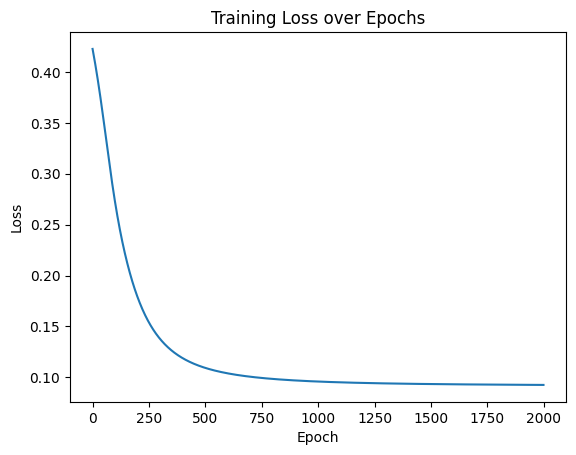

Test Accuracy: 86.00%


In [7]:
input_size = 2
hidden_size = 4
output_size = 1
model = SimpleMLP(input_size, hidden_size, output_size)

#Train  model and store the losses
losses = model.train(X_train, y_train, epochs=2000, lr=0.1)

# visulaizing the training process
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.show()

with torch.no_grad():
    test_output = model.forward(X_test)
    test_output = (test_output > 0.5).float() 
accuracy = torch.mean((test_output == y_test).float())
print(f"Test Accuracy: {accuracy.item() * 100:.2f}%")

## 方法二

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [11]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [12]:
ROOT = 'data'

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

100.0%
100.0%
100.0%
100.0%


In [13]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


In [14]:
# We have two lists of transforms, a train and a test transform. The train transforms are to artificially create more examples for our model to train on. We do not augment our test data in the same way, as we want a consistent set of examples to evaluate our final model on. The test data, however, should still be normalized.

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

# Create the datasets
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

# check the len of the datasets to see how many examples are within each
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


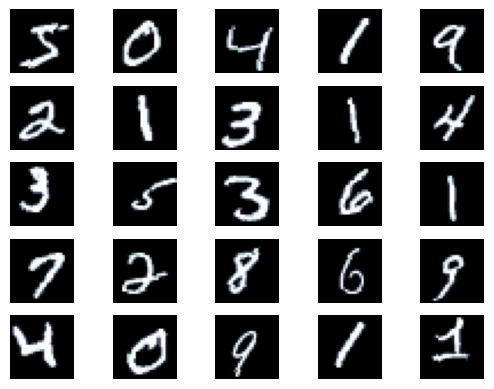

In [15]:
# look at some of the images within our dataset to see what we're working with
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

N_IMAGES = 25
images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
plot_images(images)

In [16]:
# define the exact number of examples that we want to be in each split of the training/validation sets.
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

# validation set should be  without any random augmentation.
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [25]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

first_batch = next(iter(train_iterator))
# Unpack the batch (assuming it contains data and labels)
images, batch_labels = first_batch
# Print the shapes
print(f"Shape of images in the batch: {images.shape}")
print(f"Shape of labels in the batch: {batch_labels.shape}")

Shape of images in the batch: torch.Size([64, 1, 28, 28])
Shape of labels in the batch: torch.Size([64])


In [18]:
# define the model
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        # x = [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))

        # h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))

        # h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)

        # y_pred = [batch size, output dim]

        return y_pred, h_2

In [19]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

# count the number of trainable parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Number of trainable parameters: {count_parameters(model)}')

Number of trainable parameters: 222360


In [20]:
# train the model
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# We then define device. This is used to place your model and data on to a GPU, if you have one.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
criterion = criterion.to(device)

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [21]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [22]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [23]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [26]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.404 | Train Acc: 87.33%
	 Val. Loss: 0.148 |  Val. Acc: 95.53%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.169 | Train Acc: 94.80%
	 Val. Loss: 0.096 |  Val. Acc: 97.05%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.136 | Train Acc: 95.86%
	 Val. Loss: 0.092 |  Val. Acc: 97.18%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.122 | Train Acc: 96.26%
	 Val. Loss: 0.084 |  Val. Acc: 97.33%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.108 | Train Acc: 96.61%
	 Val. Loss: 0.078 |  Val. Acc: 97.76%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.099 | Train Acc: 96.88%
	 Val. Loss: 0.091 |  Val. Acc: 97.25%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.097 | Train Acc: 96.99%
	 Val. Loss: 0.087 |  Val. Acc: 97.26%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.087 | Train Acc: 97.24%
	 Val. Loss: 0.073 |  Val. Acc: 97.82%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.084 | Train Acc: 97.40%
	 Val. Loss: 0.068 |  Val. Acc: 97.98%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 10s
	Train Loss: 0.081 | Train Acc: 97.42%
	 Val. Loss: 0.074 |  Val. Acc: 97.56%


In [27]:
# load parameters of the model that achieved the best validation loss and then use this to evaluate our model on the test set.
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.069 | Test Acc: 97.84%


## 模型检查

In [29]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

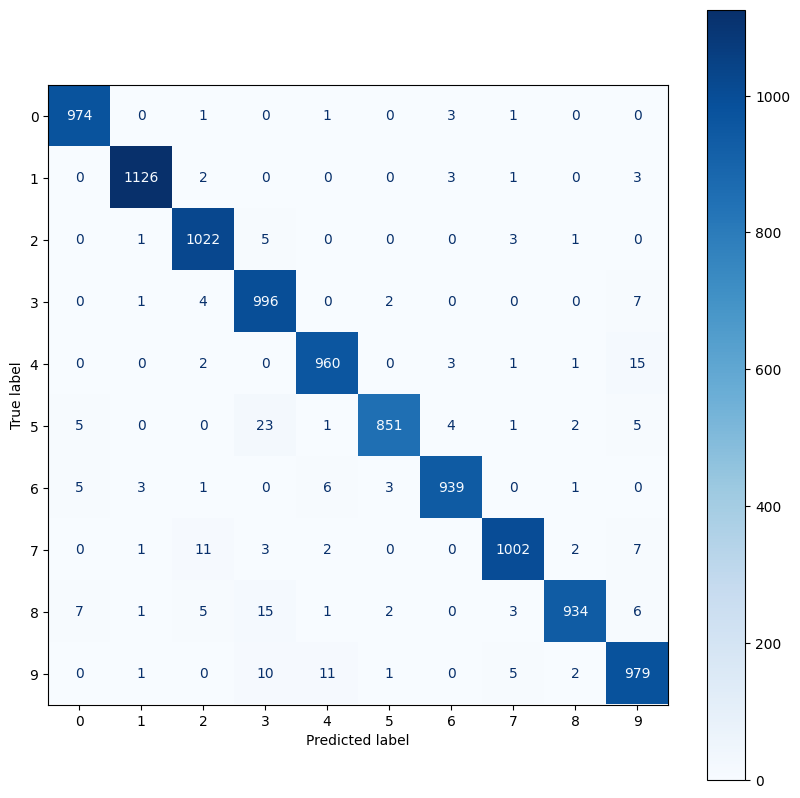

In [30]:
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

plot_confusion_matrix(labels, pred_labels)